In [17]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torch
import torchaudio

import os
import sys

from datasets import load_dataset,
from transformers import AutoConfig, Wav2Vec2FeatureExtractor

from sklearn.metrics import classification_report

In [38]:
data_files = {
    'train': '/Users/shreyas/Downloads/type3/train_multilabel.csv', 
    'valid': '/Users/shreyas/Downloads/type3/test_multilabel.csv'
    }

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_data = dataset['train']
test_data = dataset['valid']

print(train_data)
print(test_data)

Using custom data configuration default-16a54a529957e89e
Reusing dataset csv (/Users/shreyas/.cache/huggingface/datasets/csv/default-16a54a529957e89e/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
100%|██████████| 2/2 [00:00<00:00, 832.62it/s]

Dataset({
    features: ['file', 'label', 'path'],
    num_rows: 192
})
Dataset({
    features: ['file', 'label', 'path'],
    num_rows: 32
})


In [39]:
input_col = 'path'
output_col = 'label'

In [40]:
label_list = train_data.unique(output_col)
label_list.sort()
num_classes = len(label_list)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_list}")

Number of classes: 4
Classes: ['five years to dementia', 'no dementia', 'ten years to dementia', 'zero years to dementia']


In [41]:
num_labels=num_classes,
label2id={label: i for i, label in enumerate(label_list)},
id2label={i: label for i, label in enumerate(label_list)},

In [23]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

@dataclass
class SpeechClassifierModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [22]:
import torch 
import torch.nn as nn
from transformers.models.wav2vec2.modeling_wav2vec2 import (Wav2Vec2PreTrainedModel, Wav2Vec2Model)

class Wav2Vec2ClassificationHead(nn.Module):
    """head for wav2vec classification task"""
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dense(x)
        x = self.dropout(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merge_strategy(self, hidden_states, mode="mean"):
        if mode == "mean":
            return torch.mean(hidden_states, dim=1)
        elif mode == "max":
            return torch.max(hidden_states, dim=1)[0]
        elif mode == "sum":
            return torch.sum(hidden_states, dim=1)
        else:
            raise ValueError(f"Unknown merge strategy: {mode}")

    def forward(
        self,
        input_values,
        attention_mask=None,
        output_attentions=None, 
        output_hidden_states=None,
        return_dict=None,
        labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(input_values, 
                            attention_mask=attention_mask, 
                            output_attentions=output_attentions, 
                            output_hidden_states=output_hidden_states, 
                            return_dict=return_dict)  

        hidden_states = outputs[0]
        hidden_states = self.merge_strategy(hidden_states, self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierModelOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [25]:
model_name_or_path = "shreyasgite/wav2vec2-large-xls-r-300m-dementianet"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

Downloading: 100%|██████████| 1.18G/1.18G [00:45<00:00, 27.8MB/s] 


In [34]:
def speech_to_array(batch):
    speech, sr = torchaudio.load(batch["path"])
    transform = torchaudio.transforms.Resample(sr, 16000)
    speech = transform(speech)[0].numpy().squeeze()
    batch["speech"] = speech
    #return random_subsample(speech, max_length=8)
    return batch

def predict(batch):
    features = feature_extractor(batch["speech"], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [42]:
test_data = test_data.map(speech_to_array, None)


100%|██████████| 32/32 [00:00<00:00, 34.86ex/s]


In [44]:
result = test_data.map(predict, batched=True, batch_size=8)

100%|██████████| 4/4 [22:24<00:00, 336.21s/ba]


In [43]:
label_list

['five years to dementia',
 'no dementia',
 'ten years to dementia',
 'zero years to dementia']

In [68]:
y_true = [config.label2id[name] for name in result["label"]]
y_pred = result["predicted"]

y_true_labels = result["label"]
y_pred_labels = [config.id2label[id] for id in y_pred]

print(y_true)
print(y_pred)

for i in range(len(y_true)):
    if y_pred_labels[i] == y_true_labels[i]:
        print(f"{y_true_labels[i]} -> {y_pred_labels[i]}")

from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

[2, 3, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 1, 3, 0, 2, 1, 3, 0, 1, 2, 1, 0, 0, 0, 0, 3, 1, 3, 2, 0]
[2, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0]
ten years to dementia -> ten years to dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
no dementia -> no dementia
five years to dementia -> five years to dementia
no dementia -> no dementia
five years to dementia -> five years to dementia
five years to dementia -> five years to dementia
five years to dementia -> five years to dementia
five years to dementia -> five years to dementia
five years to dementia -> five years to dementia


0.375

In [63]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=label_list)
cf_matrix

array([[6, 2, 0, 0],
       [1, 5, 3, 0],
       [7, 2, 1, 0],
       [3, 2, 0, 0]])

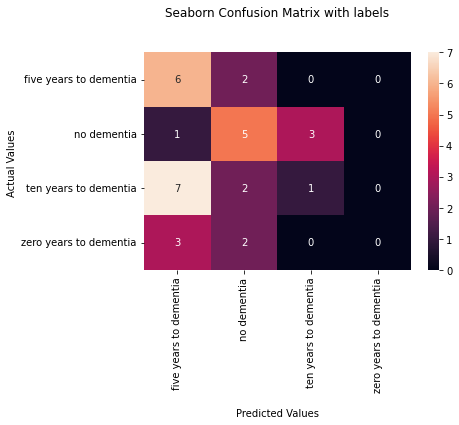

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline as mpl

cm = pd.DataFrame(cf_matrix, index = [i for i in label_list], columns = [i for i in label_list])
ax = sns.heatmap(cm, annot=True)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [47]:
print(classification_report(y_true, y_pred, target_names=label_list))

                        precision    recall  f1-score   support

five years to dementia       0.35      0.75      0.48         8
           no dementia       0.45      0.56      0.50         9
 ten years to dementia       0.25      0.10      0.14        10
zero years to dementia       0.00      0.00      0.00         5

              accuracy                           0.38        32
             macro avg       0.26      0.35      0.28        32
          weighted avg       0.29      0.38      0.31        32

